In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import zipfile

import numpy as np
import tensorflow as tf

from helpers.prepare import Word2VecSkipGramTrainingDataBuilder
from helpers.dataset import TensorFlowDataset
from models.word2vec import Word2Vec

# Load initial data

In [75]:
PATH = '../data/text8.zip'

In [118]:
with zipfile.ZipFile(PATH) as file:
    filename = file.namelist()[0]
    corpus = file.read(filename)
    corpus = tf.compat.as_str(corpus)[:50000000]

# Define some parameters

In [119]:
VOCABULARY_SIZE = 50000
BATCH_SIZE = 128
EMBEDDING_VECTOR_SIZE = 128
NEGATIVE_EXAMPLES_TO_SAMPLE_IN_SOFTMAX = 64
NUM_STEPS = 100000

# Skip-gram model

## Generate training data

In [120]:
skip_gram_training_data = Word2VecSkipGramTrainingDataBuilder.build(corpus=corpus, vocabulary_size=VOCABULARY_SIZE)

In [122]:
VALIDATION_TOKENS = [
    'united', 'four', 'first', 'system', 'his', 'than', 'would', 'seven', 
    'after', 'eight', 'three', 'new', 'their', 'they', 'it', 'people',
]
VALIDATION_TOKEN_INDICES = [
    skip_gram_training_data.token_to_index_lookup[token] for token in VALIDATION_TOKENS
]
NUM_VALIDATION_NEAREST_NEIGHBORS = 8

In [123]:
training_dataset = TensorFlowDataset(
    data=np.array(skip_gram_training_data.X_train[0]),
    labels=np.array(skip_gram_training_data.y_train[0])
)

## Build graph

In [124]:
graph = tf.Graph()

with graph.as_default():

    # datasets
    dataset = TensorFlowDataset(
        data=tf.placeholder(dtype=tf.int32, shape=[BATCH_SIZE]),
        labels=tf.placeholder(dtype=tf.int32, shape=[BATCH_SIZE, 1])
    )
    validation_data = tf.constant(VALIDATION_TOKEN_INDICES, dtype=tf.int32)
    
    # model
    model = Word2Vec(
        dataset=dataset, 
        vocabulary_size=VOCABULARY_SIZE,
        embedding_vector_size=EMBEDDING_VECTOR_SIZE,
        negative_examples_to_sample_in_softmax=NEGATIVE_EXAMPLES_TO_SAMPLE_IN_SOFTMAX
    )
    
    # normalized embeddings
    normalized_embeddings = model.compute_normalized_embeddings()
    
    # lookup validation words
    validation_embeddings = tf.nn.embedding_lookup(params=normalized_embeddings, ids=validation_data)

    # compute similarities
    similarity = tf.matmul(validation_embeddings, tf.transpose(normalized_embeddings))

In [125]:
with tf.Session(graph=graph) as session:

    session.run(tf.initialize_all_variables())
    num_training_instances = len(training_dataset.data)
    average_loss = 0

    for step in range(NUM_STEPS):
        
        # compute batch indices
        batch_start_index = step*BATCH_SIZE % num_training_instances
        if num_training_instances - batch_start_index < BATCH_SIZE:
            batch_start_index = np.random.choice(BATCH_SIZE, 1)[0]
        batch_end_index = batch_start_index + BATCH_SIZE
        
        # retrieve training batch
        training_batch_data = training_dataset.data[batch_start_index:batch_end_index]
        training_batch_labels = training_dataset.labels[batch_start_index:batch_end_index]
        training_batch_labels = training_batch_labels.reshape(-1, 1)

        # optimize
        feed_dict = {dataset.data: training_batch_data, dataset.labels: training_batch_labels}
        _, loss = session.run([model.optimize(), model.compute_loss()], feed_dict=feed_dict)
        average_loss += loss
        
        # evaluate loss
        if step % 5000 == 0 and step > 0:
            print('Average loss at step {}: {}'.format(step, average_loss / 5000))
            average_loss = 0
            
        # evaluate model on validation set
        if step % 10000 == 0 and step > 0:
            similarities = similarity.eval()
            for i, token_index in enumerate(VALIDATION_TOKEN_INDICES):
                word = skip_gram_training_data.index_to_token_lookup[token_index]
                nearest_neighbors = (-similarities[i, :]).argsort()[:NUM_VALIDATION_NEAREST_NEIGHBORS+1]
                log = 'Words nearest to \'{}\':'.format(word)
                
                for neighbor_index in nearest_neighbors:
                    neighbor_word = skip_gram_training_data.index_to_token_lookup.get(neighbor_index, 'not-in-vocabulary')
                    log = '{} {},'.format(log, neighbor_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Average loss at step 5000: 1.5055566873252393
Average loss at step 10000: 1.2589848229199647
Words nearest to 'united': united, fuel, debris, residences, ian, secondary, reactivity, kor, pollard,
Words nearest to 'four': four, two, eight, rule, zero, pediatric, wording, sy, brut,
Words nearest to 'first': first, eurosceptics, emulate, state, transverse, meir, rendering, stylization, ironic,
Words nearest to 'system': system, redefining, stirred, telco, nanometres, ranges, kernot, sphincter, breaker,
Words nearest to 'his': his, a, spartan, apokryphen, wondering, the, pleased, spend, parachuting,
Words nearest to 'than': than, cruzi, waveguide, hera, biotite, interest, norse, halley, mobutu,
Words nearest to 'would': would, pitchers, realities, speculation, platonism, amos, honorable, microbes, storefront,
Words nearest to 'seven': seven, nine, two, six, one, qualification, eight, revolves, gullit,
Words nearest to 'after': after, crony, levin, widget, ebony, fredrik, sleepers, ceres, c

# Visualize

In [126]:
from collections import Counter

from matplotlib import pylab
from sklearn.manifold import TSNE

In [127]:
words_to_plot = Counter( skip_gram_training_data.training_data_as_tokens[0] ).most_common(400)
words_to_plot = [word_count[0] for word_count in words_to_plot]

indices_to_plot = [skip_gram_training_data.token_to_index_lookup[token] for token in words_to_plot]

In [128]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_dimensional_embeddings = tsne.fit_transform(final_embeddings[indices_to_plot])

In [129]:
def plot_two_dimensional_vectors(embeddings, words):

    pylab.figure(figsize=(15,15))

    for index, word in enumerate(words):
        x, y = embeddings[index, :]
        pylab.scatter(x, y)
        pylab.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

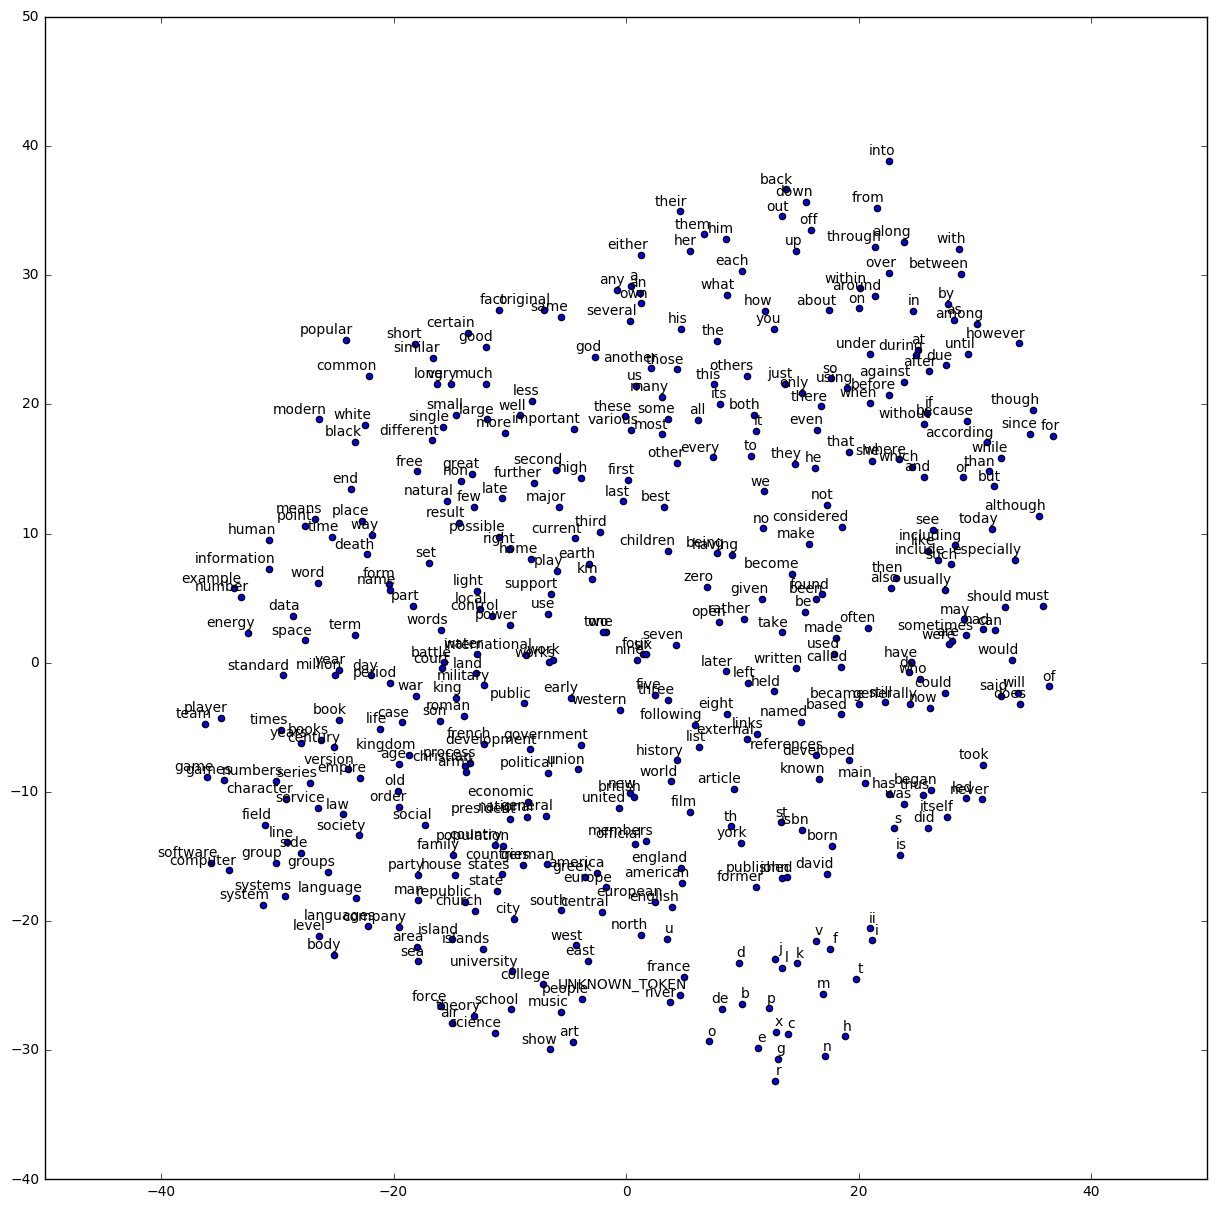

In [130]:
plot_two_dimensional_vectors(embeddings=two_dimensional_embeddings, words=words_to_plot)